# Kaggle’s 30 days of machine learning:
## Scikit-optimize for LightGBM (regression tutorial)

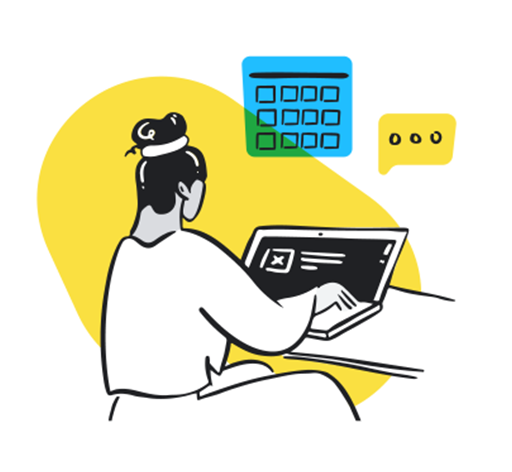

**Machine learning algorithms have lots of knobs, and success often comes from twiddling them a lot.**

*(DOMINGOS, Pedro. A few useful things to know about machine learning. Communications of the ACM, 2012, 55.10: 78-87.)*

In optimizing your model for this competition, you may wonder if there is a way to:

 * Leverage the information that you get as you explore the hyper-parameter space

 * Not necessarily become be an expert of a specific ML algorithm

 * Quickly find an optimization

The answer is:

**Bayesian Optimization** (*SNOEK, Jasper; LAROCHELLE, Hugo; ADAMS, Ryan P. Practical bayesian optimization of machine learning algorithms. In: Advances in neural information processing systems. 2012. p. 2951-2959*)

The key idea behind Bayesian optimization is that we optimize a proxy function (the surrogate function) instead than the true objective function (what actually grid search and random search both do). This holds if testing the true objective function is costly (if it is not, then we simply go for random search.

Bayesian search balances exploration against exploitation. At start it randomly explores, doing so it builds up a surrogate function of the objective. Based on that surrogate function it exploits an initial approximate knowledge of how the predictor works in order to sample more useful examples and minimize the cost function at a global level, not a local one.

Bayesian Optimization uses an acquisition function to tell us how promising an observation will be. In fact, to rule the tradeoff between exploration and exploitation, the algorithm defines an acquisition function that provides a single measure of how useful it would be to try any given point.

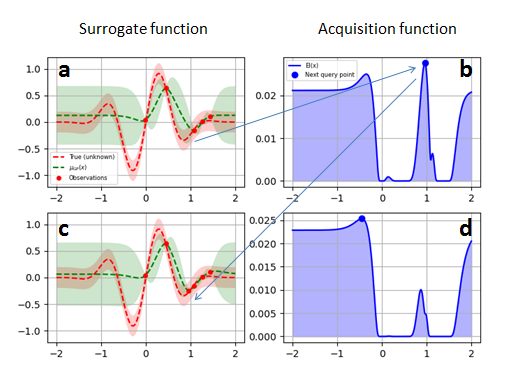

In this step by ste tutorial, you will deal Bayesian optimization using LightGBM in few clear steps:

1. Prepare your data, especially your categorical
2. Define your cross-validation strategy
3. Define your evaluation metric
4. Define your base model
5. Define your hyper-parameter search space
6. Run optimization for a while

# 1. Data preparation

As first steps:

we load the train and test data 
we separate the target from the training data
we separate the ids from the data
we convert integer variables to categories (thus our machine learning algorithm can pick them as categorical variables and not standard numeric one)

You can add further processing, for instance by feature engineering, in order to succeed in this competition

In [1]:
# Importing core libraries
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib
from functools import partial

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Classifiers
import lightgbm as lgb

# Model selection
from sklearn.model_selection import KFold

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

In [2]:
# Loading data 
X = pd.read_csv("../input/30-days-of-ml/train.csv")
X_test = pd.read_csv("../input/30-days-of-ml/test.csv")

In [3]:
# Preparing data as a tabular matrix
y = X.target
X = X.set_index('id').drop('target', axis='columns')
X_test = X_test.set_index('id')

In [4]:
# Dealing with categorical data
categoricals = [item for item in X.columns if 'cat' in item]
cat_values = np.unique(X[categoricals].values)
cat_dict = dict(zip(cat_values, range(len(cat_values))))

X[categoricals] = X[categoricals].replace(cat_dict).astype('category')
X_test[categoricals] = X_test[categoricals].replace(cat_dict).astype('category')

# Setting up optimization

First, we create a wrapper function to deal with running the optimizer and reporting back its best results.

In [5]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title="model", callbacks=None):
    """
    A wrapper for measuring time and performance of optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    
    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
        
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           + u"\u00B1"+" %.3f") % (time() - start, 
                                   len(optimizer.cv_results_['params']),
                                   best_score,
                                   best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

We then define the evaluation metric, using the Scikit-learn function make_scorer allows us to convert the optimization into a minimization problem, as required by Scikit-optimize. We set squared=False by means of a partial function to obtain the root mean squared error (RMSE) as evaluation.

In [6]:
# Setting the scoring function
scoring = make_scorer(partial(mean_squared_error, squared=False), 
                      greater_is_better=False)

We set up a  5-fold cross validation

In [7]:
# Setting the validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=0)

We set up a generic LightGBM regressor.

In [8]:
# Setting the basic regressor
reg = lgb.LGBMRegressor(boosting_type='gbdt',
                        metric='rmse',
                        objective='regression',
                        n_jobs=1, 
                        verbose=-1,
                        random_state=0)

We define a search space, expliciting the key hyper-parameters to optimize and the range where to look for the best values.


In [9]:
# Setting the search space
search_spaces = {
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),     # Boosting learning rate
    'n_estimators': Integer(30, 5000),                   # Number of boosted trees to fit
    'num_leaves': Integer(2, 512),                       # Maximum tree leaves for base learners
    'max_depth': Integer(-1, 256),                       # Maximum tree depth for base learners, <=0 means no limit
    'min_child_samples': Integer(1, 256),                # Minimal number of data in one leaf
    'max_bin': Integer(100, 1000),                       # Max number of bins that feature values will be bucketed
    'subsample': Real(0.01, 1.0, 'uniform'),             # Subsample ratio of the training instance
    'subsample_freq': Integer(0, 10),                    # Frequency of subsample, <=0 means no enable
    'colsample_bytree': Real(0.01, 1.0, 'uniform'),      # Subsample ratio of columns when constructing each tree
    'min_child_weight': Real(0.01, 10.0, 'uniform'),     # Minimum sum of instance weight (hessian) needed in a child (leaf)
    'reg_lambda': Real(1e-9, 100.0, 'log-uniform'),      # L2 regularization
    'reg_alpha': Real(1e-9, 100.0, 'log-uniform'),       # L1 regularization
   }

We then define the Bayesian optimization engine, providing to it our LightGBM, the search spaces, the evaluation metric, the cross-validation. We set a large number of possible experiments and some parallelism in the search operations.

In [10]:
# Wrapping everything up into the Bayesian optimizer
opt = BayesSearchCV(estimator=reg,                                    
                    search_spaces=search_spaces,                      
                    scoring=scoring,                                  
                    cv=kf,                                           
                    n_iter=60,                                        # max number of trials
                    n_points=3,                                       # number of hyperparameter sets evaluated at the same time
                    n_jobs=-1,                                        # number of jobs
                    iid=False,                                        # if not iid it optimizes on the cv score
                    return_train_score=False,                         
                    refit=False,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state=0)                                   # random state for replicability

Finally we runt the optimizer and wait for the results. We have set some limits to its operations: we required it to stop if it cannot get consistent improvements from the search (DeltaYStopper) and time dealine set in seconds (we decided for 6 hours).

In [11]:
# Running the optimizer
overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 60 * 6) # We impose a time limit (6 hours)

best_params = report_perf(opt, X, y,'LightGBM_regression', 
                          callbacks=[overdone_control, time_limit_control])

LightGBM_regression took 20787.21 seconds,  candidates checked: 42, best CV score: -0.721 ± 0.002
Best parameters:
OrderedDict([('colsample_bytree', 0.01),
             ('learning_rate', 1.0),
             ('max_bin', 156),
             ('max_depth', -1),
             ('min_child_samples', 241),
             ('min_child_weight', 9.715188106585181),
             ('n_estimators', 5000),
             ('num_leaves', 192),
             ('reg_alpha', 1e-09),
             ('reg_lambda', 1e-09),
             ('subsample', 1.0),
             ('subsample_freq', 1)])



# Prediction on test data

Having got the best hyperparameters for the data at hand, we instantiate a lightGBM using such values and train our model on all the available examples.

After having trained the model, we predict on the test set and we save the results on a csv file.

In [12]:
# Transferring the best parameters to our basic regressor
reg = lgb.LGBMRegressor(boosting_type='gbdt',
                        metric='rmse',
                        objective='regression',
                        n_jobs=1, 
                        verbose=-1,
                        random_state=0,
                         **best_params)

In [13]:
# Fitting the regressor on all the data
reg.fit(X, y)

LGBMRegressor(colsample_bytree=0.01, learning_rate=1.0, max_bin=156,
              metric='rmse', min_child_samples=241,
              min_child_weight=9.715188106585181, n_estimators=5000, n_jobs=1,
              num_leaves=192, objective='regression', random_state=0,
              reg_alpha=1e-09, reg_lambda=1e-09, subsample_freq=1, verbose=-1)

In [14]:
# Preparing the submission
submission = pd.DataFrame({'id':X_test.index, 
                           'target': reg.predict(X_test).ravel()})

submission.to_csv("submission.csv", index = False)

In [15]:
submission

,id,target
0,0,8.164113
1,5,8.461944
2,15,8.413098
3,16,8.431498
4,17,8.260932
...,...,...
199995,499987,8.139140
199996,499990,8.451309
199997,499991,8.506756
199998,499994,8.197716
